This builds on the previous notebook and illustrates how we can process multiple recordings from multiple subjects in a single set of code. In the previous notebook, we extracted data from a single recording and worked only with that data. This time, we will have two recordings from one subject (but this should easily expand to multiple recordings from multiple subjects). 

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl

# For brevity, limit the number of rows displayed in the default output
pd.options.display.max_rows = 10

In [ ]:
# Resampling period (in msec)
resample_period = 5

# Minimum duration of missing data for detecting a blink (in msec)
blink_duration = 10

# How many msec should we discard around the blink?
blink_padding = 25

# Duration of smoothing window (in msec)
smooth_duration = 17*16 # i.e., 17 sample window for a 16 msec period

# Type of window to use for smoothing
smooth_window = 'hamming'

# Minimum number of samples (in msec) required to be in smoothing window.
# If more than this number of samples are missing, don't calculate a value.
smooth_duration_min = smooth_duration/2

# Interpolation method to use
interpolation_method = 'linear' 

# Duration of stim to use (in msec) for pupil baseline
pupil_baseline = 2000

smooth_samples = int(smooth_duration/resample_period)
smooth_samples_min = int(smooth_duration_min/resample_period)

In [ ]:
# Read in the data file. It's tab-separated (i.e., \t) and encoded in UTF 16 format.
data_2dB = pd.read_csv('data_pilot_2dB.tsv', encoding='utf-16', sep='\t')
data_2dB['Presented Stimulus name'].fillna(method='bfill', limit=1, inplace=True)
data_2dB.dropna(subset=['Presented Stimulus name'], inplace=True)

In [ ]:
data_2dB.head()

,Participant name,Recording name,Timeline name,Recording timestamp,Pupil diameter left,Pupil diameter right,Validity left,Validity right,Event,Presented Stimulus name,Unnamed: 10
1,Participant1,Recording18,HP 2 dB,4771,NaN,NaN,NaN,NaN,VideoStimulusStart,7x2_2dB,NaN
2,Participant1,Recording18,HP 2 dB,4773,4.89,4.98,0.0,0.0,NaN,7x2_2dB,NaN
3,Participant1,Recording18,HP 2 dB,4789,4.90,4.77,0.0,0.0,NaN,7x2_2dB,NaN
4,Participant1,Recording18,HP 2 dB,4806,4.93,4.94,0.0,0.0,NaN,7x2_2dB,NaN
5,Participant1,Recording18,HP 2 dB,4823,4.84,4.96,0.0,0.0,NaN,7x2_2dB,NaN


In [ ]:
name_map = {
    'Recording timestamp': 'timestamp',
    'Pupil diameter left': 'pd_left',
    'Pupil diameter right': 'pd_right',
    'Presented Stimulus name': 'stimulus',
    'Participant name': 'subject',
    'Recording name': 'recording',
    'Timeline name': 'condition',
}

data_2dB.rename(columns=name_map, inplace=True)
keep = name_map.values()
data_2dB = data_2dB.loc[:, keep]

We need to eliminate all duplicate timestamps that occur within a recording. In the previous notebook, we grouped only by timestamp since we had one recording. This time, we need to group by subject, recording and timestamp (because the same timestamp may appear in multiple recordings).

In [ ]:
grouped = data_2dB.groupby(('subject', 'recording', 'timestamp'))
data_2dB_clean = grouped.first()
data_2dB_clean

/home/bburan/bin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


pd_left  pd_right  stimulus condition
subject      recording   timestamp                                       
Participant1 Recording18 4771           NaN       NaN   7x2_2dB   HP 2 dB
                         4773          4.89      4.98   7x2_2dB   HP 2 dB
                         4789          4.90      4.77   7x2_2dB   HP 2 dB
                         4806          4.93      4.94   7x2_2dB   HP 2 dB
                         4823          4.84      4.96   7x2_2dB   HP 2 dB
...                                     ...       ...       ...       ...
             Recording19 422691         NaN       NaN  7x49_2dB   LP 2 dB
                         422709         NaN       NaN  7x49_2dB   LP 2 dB
                         422727         NaN       NaN  7x49_2dB   LP 2 dB
                         422744         NaN       NaN  7x49_2dB   LP 2 dB
                         422761        4.31      4.28  7x49_2dB   LP 2 dB

[49690 rows x 4 columns]

For the next set of operations, it's easier to work with the subject, recording and timestamp data as columns rather than part of the index. Resetting the index converts the index to dataframe columns.

In [ ]:
data_2dB_clean.reset_index(inplace=True)
data_2dB_clean

,subject,recording,timestamp,pd_left,pd_right,stimulus,condition
0,Participant1,Recording18,4771,NaN,NaN,7x2_2dB,HP 2 dB
1,Participant1,Recording18,4773,4.89,4.98,7x2_2dB,HP 2 dB
2,Participant1,Recording18,4789,4.90,4.77,7x2_2dB,HP 2 dB
3,Participant1,Recording18,4806,4.93,4.94,7x2_2dB,HP 2 dB
4,Participant1,Recording18,4823,4.84,4.96,7x2_2dB,HP 2 dB
...,...,...,...,...,...,...,...
49685,Participant1,Recording19,422691,NaN,NaN,7x49_2dB,LP 2 dB
49686,Participant1,Recording19,422709,NaN,NaN,7x49_2dB,LP 2 dB
49687,Participant1,Recording19,422727,NaN,NaN,7x49_2dB,LP 2 dB
49688,Participant1,Recording19,422744,NaN,NaN,7x49_2dB,LP 2 dB


The next two cells define functions that will be used to facilitate resampling the dataframe and cleaning the pupil dilation.

In [ ]:
def resample_recording(recording, resample_period):
    recording = recording.copy()
    
    recording.set_index('timestamp', inplace=True)
    start = recording.index.min()
    end = recording.index.max()
    
    new_start = np.round(start/resample_period)*resample_period
    new_end = np.round(end/resample_period)*resample_period
    
    new_timestamp = np.arange(new_start, new_end, resample_period, dtype='int')
    recording_resampled = recording.reindex(new_timestamp, method='ffill')
    return recording_resampled

In [ ]:
def clean_pupil_dilation(series, 
                         smooth_samples=smooth_samples, 
                         smooth_window=smooth_window, 
                         smooth_samples_min=smooth_samples_min, 
                         interpolation_method=interpolation_method):
    
    series = series.copy()

    missing = series.isnull()
    missing_int = missing.astype('int')
    missing_diff = missing_int.diff()
 
    starts = missing_diff[missing_diff == 1]
    ends = missing_diff[missing_diff == -1]
    start_times = starts.index.values
    end_times = ends.index.values
 
    if end_times[0] < start_times[0]:
        start_times = np.r_[0, start_times]
 
    for start, end in zip(start_times, end_times):
        if end-start > blink_duration:
            lb = start - blink_padding
            ub = end + blink_padding
            series.loc[lb:ub] = np.nan
            
    window = series.rolling(smooth_samples, win_type=smooth_window, center=True, min_periods=smooth_samples_min)
    series_smoothed = window.mean()
    series_interpolated = series_smoothed.interpolate(interpolation_method)
    
    return series_interpolated

Loop through each unique subject and recording in the dataframe. For each subset of the dataframe associated with that subject and recording, resample the subset and clean up the pupil dilation data. Save the processed subset in a list. Once all subsets are processed, merge them back together creating a new dataframe.

In [ ]:
processed_subsets = []
for group_name, subset in data_2dB_clean.groupby(['subject', 'recording']):
    resampled_subset = resample_recording(subset, resample_period)
    resampled_subset['pd_left_clean'] = clean_pupil_dilation(resampled_subset['pd_left'])
    resampled_subset['pd_right_clean'] = clean_pupil_dilation(resampled_subset['pd_right'])
    
    # Since resample_recording set timestamp as an index on the dataframe, we need to
    # move the timestamp data to a column
    resampled_subset.reset_index(inplace=True)
    processed_subsets.append(resampled_subset)
    
# Concatenate the processed dataframes. We stipulate that index should be ignored because the
# concatenate function will try to align the dataframes based on the index otherwise. 
data_2dB_resampled = pd.concat(processed_subsets, ignore_index=True)
data_2dB_resampled

,timestamp,subject,recording,pd_left,pd_right,stimulus,condition,pd_left_clean,pd_right_clean
0,4770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4775,Participant1,Recording18,4.89,4.98,7x2_2dB,HP 2 dB,NaN,NaN
2,4780,Participant1,Recording18,4.89,4.98,7x2_2dB,HP 2 dB,NaN,NaN
3,4785,Participant1,Recording18,4.89,4.98,7x2_2dB,HP 2 dB,NaN,NaN
4,4790,Participant1,Recording18,4.90,4.77,7x2_2dB,HP 2 dB,NaN,NaN
...,...,...,...,...,...,...,...,...,...
166257,422735,Participant1,Recording19,NaN,NaN,7x49_2dB,LP 2 dB,4.334576,4.503962
166258,422740,Participant1,Recording19,NaN,NaN,7x49_2dB,LP 2 dB,4.334576,4.503962
166259,422745,Participant1,Recording19,NaN,NaN,7x49_2dB,LP 2 dB,4.334576,4.503962
166260,422750,Participant1,Recording19,NaN,NaN,7x49_2dB,LP 2 dB,4.334576,4.503962


Now, for each subject, recording and stimulus, compute the baseline-referenced pupil dilation. It may be possible to eliminate the recording column from groupby, but I'm not sure whether recording is important or not. Can a stimulus appear more than once in a recording? Can a stimulus appear more than once for a particular subject?

In [ ]:
grouped = data_2dB_resampled.groupby(['subject', 'recording', 'stimulus'])

processed_subsets = []
for group_name, ss in grouped:
    ss = ss.copy()
    start_ts = ss['timestamp'].min()
    ss['stim_time'] = ss['timestamp'] - start_ts
    
    m = ss['stim_time'] <= pupil_baseline
    baseline_ss = ss.loc[m]
    pd_left_baseline = baseline_ss['pd_left_clean'].mean()
    pd_right_baseline = baseline_ss['pd_right_clean'].mean()
    
    ss['pd_left_re_baseline'] = ss['pd_left_clean'] - pd_left_baseline
    ss['pd_right_re_baseline'] = ss['pd_right_clean'] - pd_right_baseline
    
    ss['pd_mean_re_baseline'] = ss[['pd_left_re_baseline', 'pd_right_re_baseline']].mean(axis='columns')
    
    processed_subsets.append(ss)
    
final = pd.concat(processed_subsets)

Plot the first 5000 msec (re stim onset) of the cleaned, baseline-referenced pupil dilation from the specified condition. The first plot shows all the traces for individual stimuli. The second plot shows the average across all stimuli.

<Figure size 432x288 with 0 Axes>

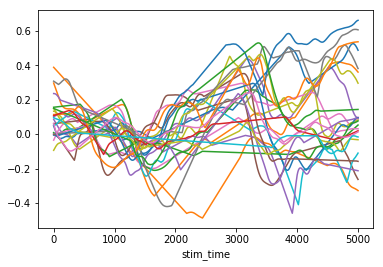

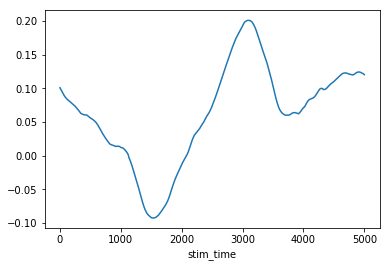

In [ ]:
pl.figure()
final.set_index(['condition', 'stimulus', 'stim_time'])[['pd_mean_re_baseline']] \
    .unstack('stimulus').loc['LP 2 dB'].loc[:5000].plot(legend=False)
    
pl.figure()
final.set_index(['condition', 'stimulus', 'stim_time'])[['pd_mean_re_baseline']] \
    .unstack('stimulus').loc['LP 2 dB'].loc[:5000].mean(axis='columns').plot(legend=False)

Now, average across all stimuli separately for each condition and timepoint. Plot the result.

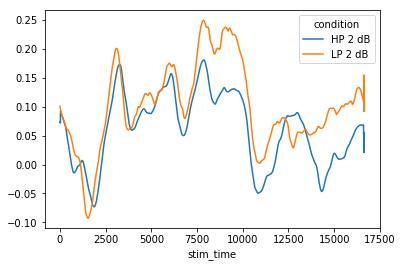

In [ ]:
grouped = final.groupby(['condition', 'stim_time'])
average = grouped['pd_mean_re_baseline'].mean()
average.unstack('condition').plot()

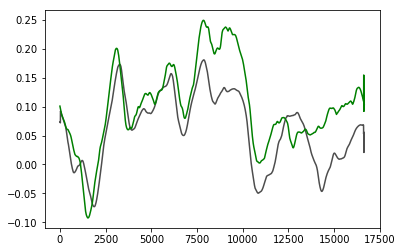

In [ ]:
plt = pl

f, ax = plt.subplots()

average_data = average.reset_index()

plot_settings = {
    'HP 8 dB': '0.8',
    'HP 5 dB': '0.6',
    'HP 2 dB': '0.3',
    'HP -1 dB':'black',
    'LP 8 dB': '',
    'LP 5 dB': '',
    'LP 2 dB': 'green',
    'LP -1 dB':'',
}

for condition, condition_data in average_data.groupby('condition'):
    color = plot_settings[condition]
    ax.plot(condition_data['stim_time'], condition_data['pd_mean_re_baseline'], 
            color=color)

In [ ]:
final.head()

,timestamp,subject,recording,pd_left,pd_right,stimulus,condition,pd_left_clean,pd_right_clean,stim_time,pd_left_re_baseline,pd_right_re_baseline,pd_mean_re_baseline
13300,71270,Participant1,Recording18,NaN,NaN,7x10_2dB,HP 2 dB,4.869141,4.796953,0,0.166903,0.156540,0.161722
13301,71275,Participant1,Recording18,NaN,NaN,7x10_2dB,HP 2 dB,4.870004,4.798373,5,0.167766,0.157961,0.162864
13302,71280,Participant1,Recording18,NaN,NaN,7x10_2dB,HP 2 dB,4.870867,4.799794,10,0.168629,0.159382,0.164006
13303,71285,Participant1,Recording18,NaN,NaN,7x10_2dB,HP 2 dB,4.871730,4.801215,15,0.169493,0.160803,0.165148
13304,71290,Participant1,Recording18,NaN,NaN,7x10_2dB,HP 2 dB,4.872593,4.802636,20,0.170356,0.162224,0.166290
